In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
import torch
torch.cuda.is_available()


False

In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 26.4 MB/s eta 0:00:00


In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
mask_predictor = SamPredictor(sam)

In [ ]:
import os
import cv2

IMAGE_PATH = "/content/truchas/0f9239d0-299c-4c42-9374-7df1d37fffe6-430mm.jpg"

In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.classes = ["trout"]
widget.enable_label = True
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(classes=['trout'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377…

In [ ]:
widget.bboxes

[{'x': 20, 'y': 35, 'width': 750, 'height': 152, 'label': 'trout'}]

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}


import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)



KeyboardInterrupt



In [ ]:
all_bboxes = widget.bboxes if hasattr(widget, 'bboxes') and widget.bboxes else [default_box]

# Listas para almacenar todas las máscaras y detecciones
all_masks = []
all_detections = []
all_labels = []


for bbox in all_bboxes:
    # Convertir el formato de la bounding box
    box = np.array([
        bbox['x'],
        bbox['y'],
        bbox['x'] + bbox['width'],
        bbox['y'] + bbox['height']
    ])

    # Predecir máscaras para esta bounding box
    masks, scores, logits = mask_predictor.predict(
        box=box,
        multimask_output=True
    )

    # Seleccionar la mejor máscara (la de mayor área)
    best_mask_idx = np.argmax([mask.sum() for mask in masks])
    best_mask = masks[best_mask_idx]

    all_masks.append(best_mask)
    all_labels.append(bbox['label'])

    # Crear una detección para esta máscara
    detection = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=np.array([best_mask])), # Convert list to NumPy array
        mask=np.array([best_mask]),
        class_id = np.array([0]) # Add class_id attribute. Assuming one class for now.
    )
    all_detections.append(detection)

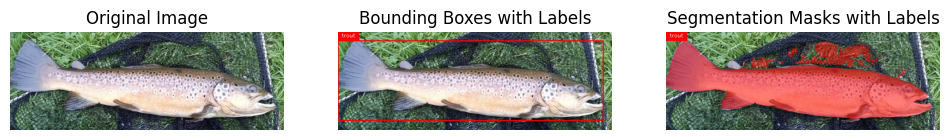

In [ ]:
combined_detections = sv.Detections.merge(all_detections)

# Create annotators
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color=sv.Color.RED, text_color=sv.Color.WHITE, text_scale=0.5)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

# Annotate the original image with bounding boxes and labels
annotated_image_boxes = box_annotator.annotate(scene=image_bgr.copy(), detections=combined_detections)
annotated_image_boxes = label_annotator.annotate(
    scene=annotated_image_boxes,
    detections=combined_detections,
    labels=all_labels
)

# Annotate the image with masks
annotated_image_masks = mask_annotator.annotate(scene=image_bgr.copy(), detections=combined_detections)
annotated_image_masks = label_annotator.annotate(
    scene=annotated_image_masks,
    detections=combined_detections,
    labels=all_labels
)

# Visualize the results
sv.plot_images_grid(
    images=[image_bgr, annotated_image_boxes, annotated_image_masks],
    grid_size=(1, 3),
    titles=['Original Image', 'Bounding Boxes with Labels', 'Segmentation Masks with Labels']
)

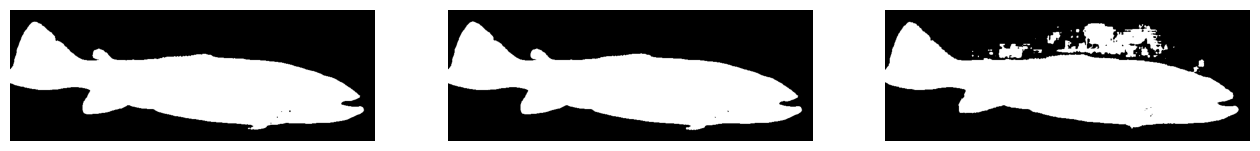

In [ ]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 3),
    size=(16, 4)
)

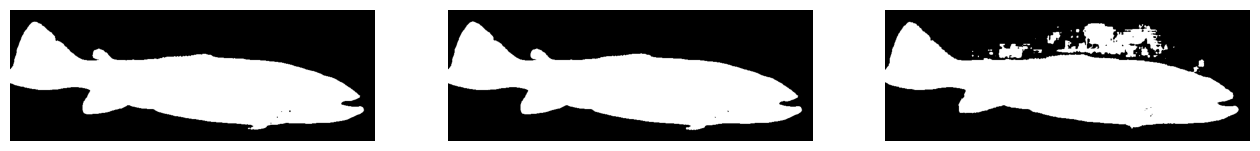

Máscara 0 ha sido guardada en /content/dataout


In [ ]:
import numpy as np
import supervision as sv
import cv2
import os

def export_and_display_selected_mask(masks, output_folder, mask_index):
    # Validar que el índice esté dentro del rango de máscaras disponibles
    if mask_index < 0 or mask_index >= len(masks):
        print(f"Índice fuera de rango. Hay {len(masks)} máscaras disponibles.")
        return

    # Crear la carpeta de salida si no existe
    os.makedirs(output_folder, exist_ok=True)

    # Seleccionar la máscara específica según el índice
    selected_mask = masks[mask_index]

    # Convertir la máscara seleccionada a imagen binaria (0 o 255)
    binary_mask = (selected_mask * 255).astype(np.uint8)

    # Guardar la máscara seleccionada
    mask_path = os.path.join(output_folder, f'{IMAGE_PATH.split("/")[3].split(".")[0]}.png')
    cv2.imwrite(mask_path, binary_mask)

    print(f"Máscara {mask_index} ha sido guardada en {output_folder}")

# Mostrar las máscaras disponibles
sv.plot_images_grid(
    images=masks,
    grid_size=(1, 3),  # Según tu ejemplo con 3 máscaras
    size=(16, 4)
)

# Elegir la máscara que deseas guardar
output_folder = '/content/dataout'  # Carpeta de salida
mask_index = 0  # Cambia el índice a 0, 1 o 2 para elegir la máscara
export_and_display_selected_mask(masks, output_folder, mask_index)


In [ ]:
import numpy as np
import supervision as sv
import cv2
import os

def calculate_mask_stability(mask):
    # Aplicar un suavizado Gaussiano para reducir el ruido
    blurred_mask = cv2.GaussianBlur(mask, (5, 5), 0)

    # Detectar contornos de la máscara
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calcular el área total del contorno
    area = sum([cv2.contourArea(c) for c in contours])

    # Calcular la cantidad de ruido (pequeñas regiones dispersas)
    noise = np.sum(mask != blurred_mask)

    # Calcular la suavidad del contorno basado en el perímetro/área
    perimeter = sum([cv2.arcLength(c, True) for c in contours])
    smoothness_ratio = perimeter / (area + 1e-6)  # Añadir epsilon para evitar división por cero

    # Combinar métricas para determinar la estabilidad (a menor valor, mejor estabilidad)
    stability_score = smoothness_ratio + noise * 0.001  # Puedes ajustar el peso del ruido
    return stability_score

def choose_most_stable_mask(masks):
    # Calcular la estabilidad para cada máscara
    stability_scores = [calculate_mask_stability(mask) for mask in masks]

    # Elegir la máscara con el menor puntaje de inestabilidad
    most_stable_index = np.argmin(stability_scores)
    return most_stable_index, stability_scores

def export_and_display_selected_mask(masks, output_folder, mask_index):
    # Validar que el índice esté dentro del rango de máscaras disponibles
    if mask_index < 0 or mask_index >= len(masks):
        print(f"Índice fuera de rango. Hay {len(masks)} máscaras disponibles.")
        return

    # Crear la carpeta de salida si no existe
    os.makedirs(output_folder, exist_ok=True)

    # Seleccionar la máscara específica según el índice
    selected_mask = masks[mask_index]

    # Convertir la máscara seleccionada a imagen binaria (0 o 255)
    binary_mask = (selected_mask * 255).astype(np.uint8)

    # Guardar la máscara seleccionada
    mask_path = os.path.join(output_folder, f'{IMAGE_PATH.split("/")[3].split(".")[0]}.png')
    cv2.imwrite(mask_path, binary_mask)

    print(f"Máscara {mask_index} ha sido guardada en {output_folder}")

# Mostrar las máscaras disponibles
sv.plot_images_grid(
    images=masks,
    grid_size=(1, 3),  # Según tu ejemplo con 3 máscaras
    size=(16, 4)
)

# Elegir la máscara más estable según el análisis
most_stable_index, stability_scores = choose_most_stable_mask(masks)
print(f"La máscara más estable es la de índice {most_stable_index} con puntaje de estabilidad {stability_scores[most_stable_index]}")

# Exportar la máscara seleccionada
output_folder = '/content/dataout'  # Carpeta de salida
export_and_display_selected_mask(masks, output_folder, most_stable_index)
